# Importing the Libraries

In [17]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

In [30]:
pd.set_option("display.max_rows", 100)

# Loading the Data

In [2]:
data = pd.read_csv("../data/processed/data_outliers_treated.csv")
data.head()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
0,NTM3,X1,A28,WHOLESALE,Large,Powder,May-21,10.16
1,NTM2,X1,A9,DIRECT,Large,Powder,Oct-20,134.28
2,NTM3,X2,A20,DIRECT,Large,Powder,Dec-20,12.46
3,NTM3,X1,A18,WHOLESALE,Small,Powder,Feb-21,107.22
4,NTM2,X1,A28,DIRECT,Large,Liquid,Nov-20,197.76


<B>In this notebook, the goal is to build a baseline model, just using the one hot encoded values for all categorical columns, and taking the month number from the 'Month of Sourcing'.</B>

### Grouping the data

Since the data is outlier-treated, it is safe to aggregate and take mean of Sourcing Cost for each unique product combination for each data and model on top of that

Metrics MAE and RMSE will be used to validate the model performance

In [21]:
def preprocess_data(data):
    df_grouped = data.groupby(data.columns.tolist()[:-1], as_index = False).agg({'Sourcing Cost': ['mean']})
    df_grouped.columns = ["_".join(x).rstrip("_") for x in df_grouped.columns.ravel()]
    df_grouped['Month of Sourcing'] = df_grouped['Month of Sourcing'].apply(lambda x: datetime.strptime("01-" + x, '%d-%b-%y')) 
    df_grouped.columns = [column.replace(" ", "_") for column in df_grouped.columns]
    df_dummies = pd.get_dummies(df_grouped, drop_first = True)
    df_dummies['Month_of_Sourcing'] = df_dummies['Month_of_Sourcing'].dt.month
    return df_dummies

In [10]:
df_grouped = data.groupby(data.columns.tolist()[:-1], as_index = False).agg({'Sourcing Cost': ['mean']})
df_grouped.columns = ["_".join(x).rstrip("_") for x in df_grouped.columns.ravel()]
df_grouped['Month of Sourcing'] = df_grouped['Month of Sourcing'].apply(lambda x: datetime.strptime("01-" + x, '%d-%b-%y')) 
df_grouped.columns = [column.replace(" ", "_") for column in df_grouped.columns]
df_grouped.head()


,ProductType,Manufacturer,Area_Code,Sourcing_Channel,Product_Size,Product_Type,Month_of_Sourcing,Sourcing_Cost_mean
0,NTM1,X1,A1,DIRECT,Small,Powder,2021-04-01,92.813339
1,NTM1,X1,A1,DIRECT,Small,Powder,2020-08-01,94.795753
2,NTM1,X1,A1,DIRECT,Small,Powder,2020-12-01,106.372132
3,NTM1,X1,A1,DIRECT,Small,Powder,2021-02-01,93.484534
4,NTM1,X1,A1,DIRECT,Small,Powder,2021-01-01,91.816050


<b>Dummy Encoding all Categorical Features </b>

In [11]:
df_dummies = pd.get_dummies(df_grouped, drop_first = True)
df_dummies['Month_of_Sourcing'] = df_dummies['Month_of_Sourcing'].dt.month
df_dummies.head()

,Month_of_Sourcing,Sourcing_Cost_mean,ProductType_NTM2,ProductType_NTM3,Manufacturer_X2,Manufacturer_X3,Area_Code_A10,Area_Code_A11,Area_Code_A12,Area_Code_A13,...,Area_Code_A6,Area_Code_A7,Area_Code_A8,Area_Code_A9,Sourcing_Channel_ECOM,Sourcing_Channel_RETAIL,Sourcing_Channel_WHOLESALE,Product_Size_Large,Product_Size_Small,Product_Type_Powder
0,4,92.813339,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,8,94.795753,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,12,106.372132,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,2,93.484534,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,1,91.816050,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [12]:
x_train, x_test, y_train, y_test = train_test_split(df_dummies.drop(columns = ['Sourcing_Cost_mean']),
                                                   df_dummies[['Sourcing_Cost_mean']], test_size = 0.3, 
                                                   shuffle = True, random_state = 70)


In [13]:
model = XGBRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)


In [15]:
df_final = pd.DataFrame()
df_final['y_test']  = y_test['Sourcing_Cost_mean']
df_final['y_pred'] = y_pred
df_final.reset_index(inplace = True, drop = True)
df_final.head()


,y_test,y_pred
0,141.779010,138.895081
1,133.300000,136.383423
2,18.765257,55.499783
3,42.996422,69.778236
4,264.960000,209.407639


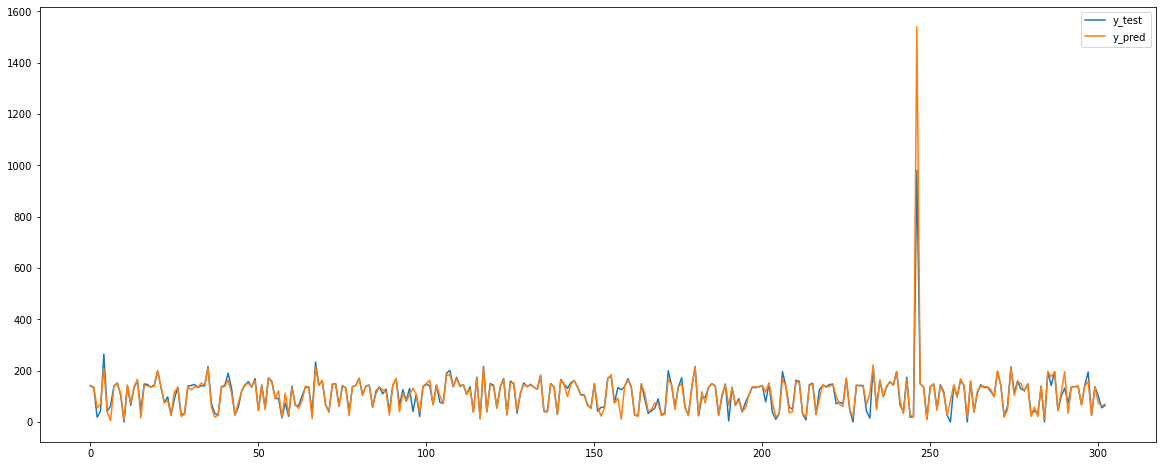

In [18]:
df_final.plot(figsize = (20, 8))
plt.show()

### Testing on The Final Data

In [20]:
df_test = pd.read_csv("../data/raw/DS_ML Coding Challenge Dataset - Test Dataset.csv")
df_test.head()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
0,NTM1,X1,A1,DIRECT,Small,Powder,Jun-21,103.68
1,NTM1,X1,A10,DIRECT,Large,Powder,Jun-21,155.75
2,NTM1,X1,A10,ECOM,Large,Powder,Jun-21,143.02
3,NTM1,X1,A11,DIRECT,Large,Powder,Jun-21,139.39
4,NTM1,X1,A2,DIRECT,Large,Powder,Jun-21,169.42


In [22]:
df_processed = preprocess_data(df_test)

In [23]:
df_processed.head()

,Month_of_Sourcing,Sourcing_Cost_mean,ProductType_NTM2,ProductType_NTM3,Manufacturer_X2,Manufacturer_X3,Area_Code_A10,Area_Code_A11,Area_Code_A12,Area_Code_A13,...,Area_Code_A6,Area_Code_A7,Area_Code_A8,Area_Code_A9,Sourcing_Channel_ECOM,Sourcing_Channel_RETAIL,Sourcing_Channel_WHOLESALE,Product_Size_Large,Product_Size_Small,Product_Type_Powder
0,6,103.68,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,6,155.75,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,6,143.02,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,1
3,6,139.39,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
4,6,169.42,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [24]:
X_t = df_processed.drop(['Sourcing_Cost_mean'], axis = 1)

In [26]:
y_pred = model.predict(X_t)

In [27]:
df_final = pd.DataFrame()
df_final['y_test']  = df_processed['Sourcing_Cost_mean']
df_final['y_pred'] = y_pred
df_final.reset_index(inplace = True, drop = True)
df_final.head()

,y_test,y_pred
0,103.68,117.798241
1,155.75,140.902893
2,143.02,133.964493
3,139.39,137.294205
4,169.42,154.715378


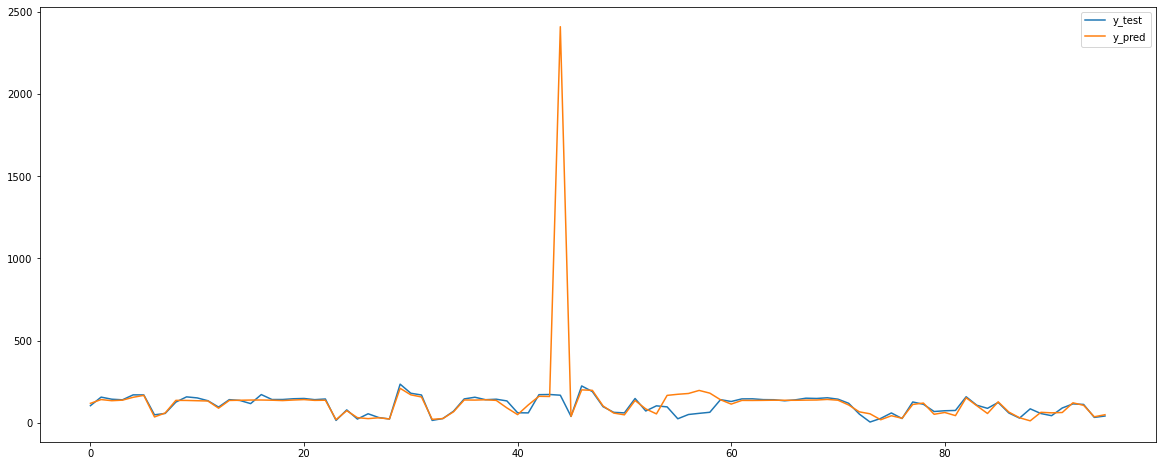

In [28]:
df_final.plot(figsize = (20, 8))
plt.show()

In [36]:
print(f"Mean Absolute Error: {mean_absolute_error(df_final['y_test'], df_final['y_pred'])}")
print(f"Roto Mean Squared Error: {np.sqrt(mean_squared_error(df_final['y_test'], df_final['y_pred']))}")


Mean Absolute Error: 40.97983494400978
Roto Mean Squared Error: 231.2891073053113
